In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/M2/Vision/ffhq.zip' # original
!unzip '/content/drive/MyDrive/M2/Vision/stylegan_ffhq.zip' # forged
!unzip '/content/drive/MyDrive/M2/Vision/stylegan_celeba.zip' # forged

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: stylegan_celeba/train/F_SyCA_00004.png  
  inflating: stylegan_celeba/train/F_SyCA_00006.png  
  inflating: stylegan_celeba/train/F_SyCA_00037.png  
  inflating: stylegan_celeba/train/F_SyCA_00060.png  
  inflating: stylegan_celeba/train/F_SyCA_00074.png  
  inflating: stylegan_celeba/train/F_SyCA_00087.png  
  inflating: stylegan_celeba/train/F_SyCA_00098.png  
  inflating: stylegan_celeba/train/F_SyCA_00099.png  
  inflating: stylegan_celeba/train/F_SyCA_00106.png  
  inflating: stylegan_celeba/train/F_SyCA_00117.png  
  inflating: stylegan_celeba/train/F_SyCA_00131.png  
  inflating: stylegan_celeba/train/F_SyCA_00162.png  
  inflating: stylegan_celeba/train/F_SyCA_00180.png  
  inflating: stylegan_celeba/train/F_SyCA_00181.png  
  inflating: stylegan_celeba/train/F_SyCA_00197.png  
  inflating: stylegan_celeba/train/F_SyCA_00206.png  
  inflating: stylegan_celeba/train/F_SyCA_00223.png  
  inflating: stylegan_celeba/train/F_SyCA_0022

In [4]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.1 MB/s eta 0:00:00


In [5]:
!pip install progress

  Preparing metadata (setup.py) ... done
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9614 sha256=9baad2d7cdf3e45b1974a69e283eb1529c6ddca2184dc56d85f49c56e506e75d
  Stored in directory: /root/.cache/pip/wheels/a2/68/5f/c339b20a41659d856c93ccdce6a33095493eb82c3964aac5a1
Successfully built progress


In [6]:
import os
import random
import math
import yaml
import argparse
import collections
from progress.bar import Bar

import numpy as np
from PIL import Image
import torch
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from multiprocessing import Manager

In [7]:
!ls

drive  efficientnet  efficient-vit  ffhq  sample_data  stylegan_celeba	stylegan_ffhq


In [8]:
%cd /content/efficientnet/
from model import EfficientNet

/content/efficientnet


In [9]:
%cd /content/efficient-vit/
from dataset import DeepFakesDataset
from efficient_vit import EfficientViT
from utils import get_method, check_correct, resize, shuffle_dataset, create_label, get_n_params

/content/efficient-vit


In [11]:
%cd /content

/content


In [12]:
# ffhq : R_FFHQ_11000.png
# stylegan_celeba : F_SyCA_11000.png
# stylegan_ffhq : F_SyFQ_10000.png
def getDataset(dataSrcPath:str) -> tuple :
    tr = {'ffhq':None, 'stylegan_ffhq':None, 'stylegan_celeba':None}
    vl = {'ffhq':None, 'stylegan_ffhq':None, 'stylegan_celeba':None}
    ts = {'ffhq':None, 'stylegan_ffhq':None, 'stylegan_celeba':None}

    for k in tr.keys():
        try:
          # images
          tr[k] = [os.path.join(dataSrcPath, k, 'train', img) for img in os.listdir(os.path.join(dataSrcPath, k, 'train'))]
          vl[k] = [os.path.join(dataSrcPath, k, 'validation', img) for img in os.listdir(os.path.join(dataSrcPath, k, 'validation'))]
          ts[k] = [os.path.join(dataSrcPath, k, 'test', img) for img in os.listdir(os.path.join(dataSrcPath, k, 'test'))]
        except:
          print(f"data {k} does not exist")
    return tr, vl, ts

In [13]:
def save_roc_curves(correct_labels, preds, model_name, accuracy, loss, f1):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, th = metrics.roc_curve(correct_labels, preds)

    auc_model = metrics.auc(fpr, tpr)

    youden_index = tpr - fpr
    optimal_threshold_index = np.argmax(youden_index)
    optimal_threshold = th[optimal_threshold_index]
    print(f'Threshold optimal: {optimal_threshold:.5f}')

    plt.plot(fpr, tpr, label="Model_" + model_name + ' (area = {:.3f})'.format(auc_model))
    plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], color='red', label='Optimal threshold')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, th, auc_model

In [15]:
# dataset
DATAPATH = '/content/' #opt.trainpath
with open('./efficient-vit/configs/configuration.yaml', 'r') as ymlfile:
    config = yaml.safe_load(ymlfile)

# trainset, validset, testset = get_data_pair(DATAPATH)
_, _, ts = getDataset(DATAPATH)
testset = ts['ffhq'] + ts['stylegan_ffhq'] + ts['stylegan_celeba']

# create labels
tslb = create_label(testset, DFcheckStr='F_Sy')

testset = (testset, tslb)
test_samples = len(testset[0])

# Print some statistics
print("Test images:", test_samples)
print("__TEST STATS__")
test_counters = collections.Counter(image for image in testset[1])
print(test_counters)
class_weights = test_counters[0] / test_counters[1]
print("Weights", class_weights)
print("___________________")

# test_labels = testset[1]
# apply transforms
testset = DeepFakesDataset(testset[0], testset[1], config['model']['image-size'], mode='validation')
# del testloader
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, sampler=None,
                                          batch_sampler=None, num_workers=2, collate_fn=None,
                                          pin_memory=False, drop_last=False, timeout=0,
                                          worker_init_fn=None, prefetch_factor=2,
                                          persistent_workers=False)
# del testset

Test images: 26997
__TEST STATS__
Counter({0: 17997, 1: 9000})
Weights 1.9996666666666667
___________________


In [17]:
channels = 1280

models = 'efficientvit'
if models:
    if models == 'efficientvit':
        model = EfficientViT(config=config, channels=channels, selected_efficient_net=1)
    elif models == 'efficientnet':
        model = EfficientViT(config=config, channels=channels, selected_efficient_net=1, vit=False)
    state_dict_path = "/content/drive/MyDrive/M2/Vision/efficientnetB1_ViT_checkpoint29_test"
    if os.path.exists(state_dict_path):
        model.load_state_dict(torch.load(state_dict_path))
        print("state dict loaded.")
        model.eval()
        model = model.cuda()
    else:
        print("No model found.")
        exit()
else:
    print("Model architecture not defined.")
    exit()

model_name = os.path.basename(state_dict_path)

OUTPUT_DIR = config['inference']['infer-path']
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

mgr = Manager()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 323MB/s]


Loaded pretrained weights for efficientnet-b1
Efficientnet-b1 will be using.
Vision Transformer will be attached to the efficientnet.
state dict loaded.


# eff0
- ffhq + stylegan_ffhq

In [ ]:
correct_test_labels = np.asarray(tslb)
preds = []
# videos = np.asarray([row[0] for row in videos])

bar = Bar('Predicting', max=len(testset[0]))

# f = open(OUTPUT_DIR + model_name + "_labels.txt", "w+")
import time
begin = time.time()
with torch.no_grad():
    for index, (images, labels) in enumerate(testloader):
        images = np.transpose(images, (0, 3, 1, 2))
        images = images.cuda()
        labels = labels.unsqueeze(1)

        pred = model(images)
        pred = pred.cpu()
        pred = [np.asarray(torch.sigmoid(p).detach()) for p in pred]
        preds.extend(pred)

        bar.next()
later = time.time()
difference = int(later - begin)
print(f"#inference time: {difference}s")
bar.finish()

#inference time: 108s


efficientnetB0_checkpoint29_test Loss: 0.6694325 Test Accuracy: 0.7800188920375618 F1 0.7858726810535994
Threshold optimal: 0.52799


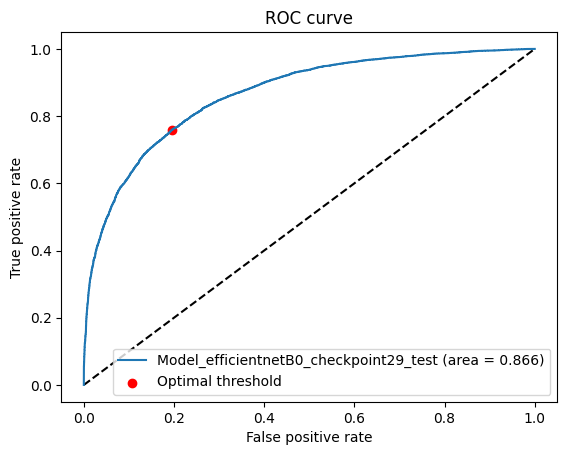

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
tensor_labels = torch.tensor([[float(label)] for label in correct_test_labels])
tensor_preds = torch.tensor(preds)

loss = loss_fn(tensor_preds, tensor_labels).numpy()
accuracy = accuracy_score(np.asarray(preds).round(), correct_test_labels)

f1 = f1_score(correct_test_labels, np.asarray(preds).round())
print(model_name, "Loss:", loss, "Test Accuracy:", accuracy, "F1", f1)

fpr, tpr, th, auc = save_roc_curves(correct_test_labels, preds, model_name, accuracy, loss, f1)

- ffhq + stylegan_ffhq + stylegan_celebA

In [ ]:
correct_test_labels = np.asarray(tslb)
preds = []
# videos = np.asarray([row[0] for row in videos])

bar = Bar('Predicting', max=len(testset[0]))

# f = open(OUTPUT_DIR + model_name + "_labels.txt", "w+")
import time
begin = time.time()
with torch.no_grad():
    for index, (images, labels) in enumerate(testloader):
        images = np.transpose(images, (0, 3, 1, 2))
        images = images.cuda()
        labels = labels.unsqueeze(1)

        pred = model(images)
        pred = pred.cpu()
        pred = [np.asarray(torch.sigmoid(p).detach()) for p in pred]
        preds.extend(pred)

        bar.next()
later = time.time()
difference = int(later - begin)
print(f"#inference time: {difference}s")
bar.finish()

#inference time: 179s


efficientnetB0_checkpoint29_test Loss: 0.7458355 Test Accuracy: 0.794273437789384 F1 0.7234614618601872
Threshold optimal: 0.51242


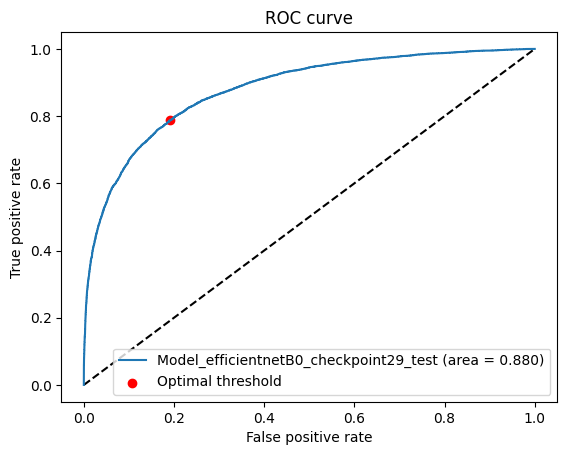

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
tensor_labels = torch.tensor([[float(label)] for label in correct_test_labels])
tensor_preds = torch.tensor(preds)

loss = loss_fn(tensor_preds, tensor_labels).numpy()
accuracy = accuracy_score(np.asarray(preds).round(), correct_test_labels)

f1 = f1_score(correct_test_labels, np.asarray(preds).round())
print(model_name, "Loss:", loss, "Test Accuracy:", accuracy, "F1", f1)

fpr, tpr, th, auc = save_roc_curves(correct_test_labels, preds, model_name, accuracy, loss, f1)

# eff0 + ViT
- ffhq + stylegan_ffhq

In [ ]:
correct_test_labels = np.asarray(tslb)
preds = []
# videos = np.asarray([row[0] for row in videos])

bar = Bar('Predicting', max=len(testset[0]))

# f = open(OUTPUT_DIR + model_name + "_labels.txt", "w+")
import time
begin = time.time()
with torch.no_grad():
    for index, (images, labels) in enumerate(testloader):
        images = np.transpose(images, (0, 3, 1, 2))
        images = images.cuda()
        labels = labels.unsqueeze(1)

        pred = model(images)
        pred = pred.cpu()
        pred = [np.asarray(torch.sigmoid(p).detach()) for p in pred]
        preds.extend(pred)

        bar.next()
later = time.time()
difference = int(later - begin)
print(f"#inference time: {difference}s")
bar.finish()

#inference time: 116s


efficientnetB0_checkpoint29_test Loss: 0.5476865 Test Accuracy: 0.9242651553036617 F1 0.9223494559334587
Threshold optimal: 0.39219


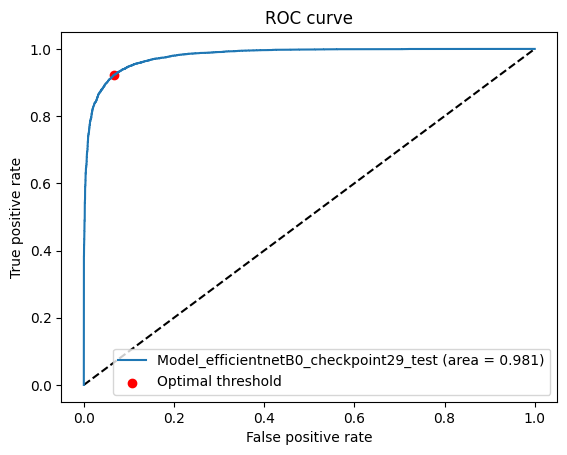

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
tensor_labels = torch.tensor([[float(label)] for label in correct_test_labels])
tensor_preds = torch.tensor(preds)

loss = loss_fn(tensor_preds, tensor_labels).numpy()
accuracy = accuracy_score(np.asarray(preds).round(), correct_test_labels)

f1 = f1_score(correct_test_labels, np.asarray(preds).round())
print(model_name, "Loss:", loss, "Test Accuracy:", accuracy, "F1", f1)

fpr, tpr, th, auc = save_roc_curves(correct_test_labels, preds, model_name, accuracy, loss, f1)

- ffhq + stylegan_ffhq + stylegan_celebA

In [ ]:
correct_test_labels = np.asarray(tslb)
preds = []
# videos = np.asarray([row[0] for row in videos])

bar = Bar('Predicting', max=len(testset[0]))

# f = open(OUTPUT_DIR + model_name + "_labels.txt", "w+")
import time
begin = time.time()
with torch.no_grad():
    for index, (images, labels) in enumerate(testloader):
        images = np.transpose(images, (0, 3, 1, 2))
        images = images.cuda()
        labels = labels.unsqueeze(1)

        pred = model(images)
        pred = pred.cpu()
        pred = [np.asarray(torch.sigmoid(p).detach()) for p in pred]
        preds.extend(pred)

        bar.next()
later = time.time()
difference = int(later - begin)
print(f"#inference time: {difference}s")
bar.finish()

#inference time: 195s


<ipython-input-26-efb0b0fc05ae>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  tensor_preds = torch.tensor(preds)


efficientnetB0_ViT_checkpoint29_test Loss: 0.62538975 Test Accuracy: 0.9120643034411231 F1 0.8721593968766829
Threshold optimal: 0.45461


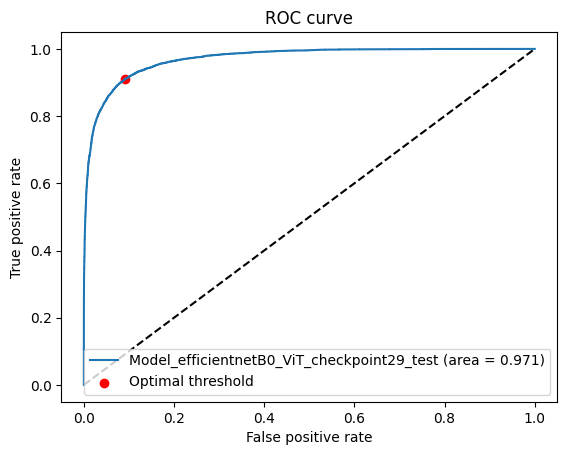

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
tensor_labels = torch.tensor([[float(label)] for label in correct_test_labels])
tensor_preds = torch.tensor(preds)

loss = loss_fn(tensor_preds, tensor_labels).numpy()
accuracy = accuracy_score(np.asarray(preds).round(), correct_test_labels)

f1 = f1_score(correct_test_labels, np.asarray(preds).round())
print(model_name, "Loss:", loss, "Test Accuracy:", accuracy, "F1", f1)

fpr, tpr, th, auc = save_roc_curves(correct_test_labels, preds, model_name, accuracy, loss, f1)

# eff1 + ViT
- ffhq + stylegan_ffhq

In [ ]:
correct_test_labels = np.asarray(tslb)
preds = []
# videos = np.asarray([row[0] for row in videos])

bar = Bar('Predicting', max=len(testset[0]))

# f = open(OUTPUT_DIR + model_name + "_labels.txt", "w+")
import time
from tqdm import tqdm
begin = time.time()
with torch.no_grad():
    for index, (images, labels) in tqdm(enumerate(testloader)):
        images = np.transpose(images, (0, 3, 1, 2))
        images = images.cuda()
        labels = labels.unsqueeze(1)

        pred = model(images)
        pred = pred.cpu()
        pred = [np.asarray(torch.sigmoid(p).detach()) for p in pred]
        preds.extend(pred)

        bar.next()
later = time.time()
difference = int(later - begin)
print(f"#inference time: {difference}s")
bar.finish()

563it [02:11,  4.29it/s]

#inference time: 131s


<ipython-input-19-efb0b0fc05ae>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  tensor_preds = torch.tensor(preds)


efficientnetB1_ViT_checkpoint29_test Loss: 0.54871005 Test Accuracy: 0.935544813024393 F1 0.9357269503546098
Threshold optimal: 0.49096


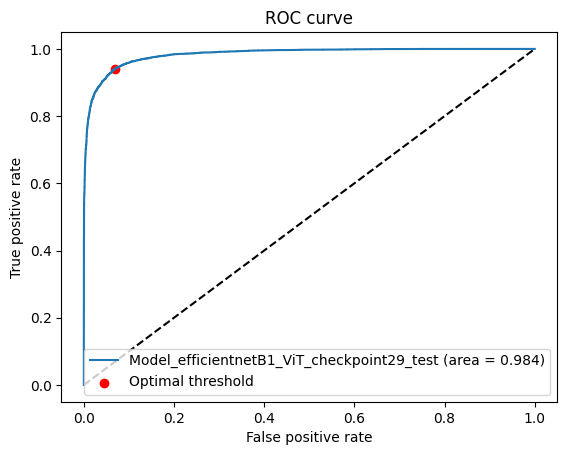

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
tensor_labels = torch.tensor([[float(label)] for label in correct_test_labels])
tensor_preds = torch.tensor(preds)

loss = loss_fn(tensor_preds, tensor_labels).numpy()
accuracy = accuracy_score(np.asarray(preds).round(), correct_test_labels)

f1 = f1_score(correct_test_labels, np.asarray(preds).round())
print(model_name, "Loss:", loss, "Test Accuracy:", accuracy, "F1", f1)

fpr, tpr, th, auc = save_roc_curves(correct_test_labels, preds, model_name, accuracy, loss, f1)

- ffhq + stylegan_ffhq + stylegan_celebA

In [18]:
correct_test_labels = np.asarray(tslb)
preds = []
# videos = np.asarray([row[0] for row in videos])

bar = Bar('Predicting', max=len(testset[0]))

# f = open(OUTPUT_DIR + model_name + "_labels.txt", "w+")
import time
begin = time.time()
with torch.no_grad():
    for index, (images, labels) in enumerate(testloader):
        images = np.transpose(images, (0, 3, 1, 2))
        images = images.cuda()
        labels = labels.unsqueeze(1)

        pred = model(images)
        pred = pred.cpu()
        pred = [np.asarray(torch.sigmoid(p).detach()) for p in pred]
        preds.extend(pred)

        bar.next()
later = time.time()
difference = int(later - begin)
print(f"#inference time: {difference}s")
bar.finish()

#inference time: 215s


<ipython-input-19-efb0b0fc05ae>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  tensor_preds = torch.tensor(preds)


efficientnetB1_ViT_checkpoint29_test Loss: 0.63635314 Test Accuracy: 0.901544616068452 F1 0.8640130973089123
Threshold optimal: 0.57831


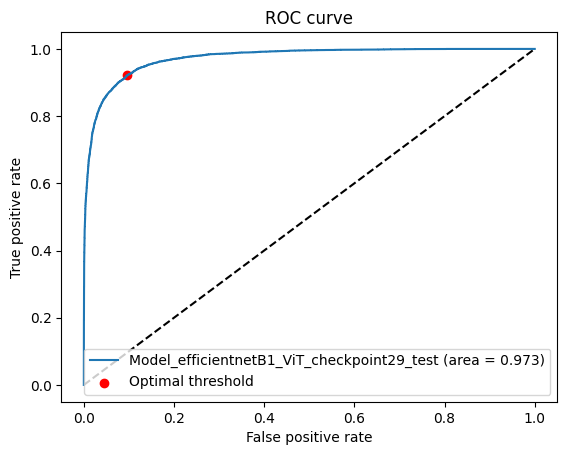

In [19]:
loss_fn = torch.nn.BCEWithLogitsLoss()
tensor_labels = torch.tensor([[float(label)] for label in correct_test_labels])
tensor_preds = torch.tensor(preds)

loss = loss_fn(tensor_preds, tensor_labels).numpy()
accuracy = accuracy_score(np.asarray(preds).round(), correct_test_labels)

f1 = f1_score(correct_test_labels, np.asarray(preds).round())
print(model_name, "Loss:", loss, "Test Accuracy:", accuracy, "F1", f1)

fpr, tpr, th, auc = save_roc_curves(correct_test_labels, preds, model_name, accuracy, loss, f1)